# model_A.ipynb
Author: Connacher Murphy

See documentation for a discussion of this implementation.

## 0. Libraries

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import qsm_calibration as qsmc
import qsm_solver_mA as qsmA

## 1. Calibration
We create the commuting flows matrix $\mathbf{\pi}$, where $\pi_{i n}$ denotes the share of workers living in neighborhood $i$ commuting to neighborhood $n$.

In [44]:
(  # calibrate() returns objects needed for models A and B
    pi,
    pi_cond,
    residents,
    workers,
    R_bar,
    wages,
    num_nbhd,
    far_southeast_indices,
    employment_core_indices,
    neighborhoods_shp,
    theta,
    alpha,
    beta,
) = qsmc.calibrate()

## 2. Counterfactual solver
Following the notation in the writeup, I let $i$ correspond to the first index and $n$ to the second.

In [45]:
# Unit test
# calc_Z should return all zeros if we guess the correct wage changes
# We can set all parameter proportional changes to 1 (no changes) and check
# that a vector of unchanged wages is an equilibrium
w_tilde = np.ones((1, num_nbhd))  # use the second index to follow tilde(w)_n notation
A_hat = np.ones((1, num_nbhd))
R_hat = np.ones((num_nbhd, 1))
kappa_hat = np.ones((num_nbhd, num_nbhd))

Z = qsmA.calc_Z(w_tilde, theta, alpha, pi, residents, workers, A_hat, kappa_hat, R_hat)

print(f"Maximum absolute value of Z_i: {abs(Z).max()}")
print(f"Z nan values: {np.sum(np.isnan(Z))}")

Maximum absolute value of Z_i: 1.1102230246251565e-16
Z nan values: 0


In [46]:
# Run the unit test again, using the solve_counterfactual() function
w_hat = qsmA.solve_counterfactual(
    num_nbhd, theta, alpha, pi, residents, workers, A_hat, kappa_hat, R_hat
)

print(f"Maximum absolute value of (w_hat - 1): {abs(w_hat - 1).max()}")
print(f"w_hat nan values: {np.sum(np.isnan(w_hat))}")

Step 0 error: 0.0
Maximum absolute value of (w_hat - 1): 0.0
w_hat nan values: 0


## 3. Counterfactual exercises

### 3.i. Local productivity shock

In [47]:
print("Local productivity shock in far southeast")

A_hat[:, far_southeast_indices] = 1.05  # increase productivity by 5% in far southeast
w_hat = qsmA.solve_counterfactual(
    num_nbhd, theta, alpha, pi, residents, workers, A_hat, kappa_hat, R_hat
)

productivity_shock_shp = qsmA.summarize_counterfactual(
    num_nbhd, neighborhoods_shp, w_hat
)

Local productivity shock in far southeast
Step 0 error: 0.1297263219
Step 1 error: 0.0603006826
Step 2 error: 0.0285251139
Step 3 error: 0.0136829422
Step 4 error: 0.0066695423
Step 5 error: 0.0033224206
Step 6 error: 0.0017055958
Step 7 error: 0.0009111593
Step 8 error: 0.0005111351
Step 9 error: 0.0003027803
Step 10 error: 0.000189409
Step 11 error: 0.0001244453
Step 12 error: 8.51049e-05
Step 13 error: 5.99853e-05
Step 14 error: 4.31953e-05
Step 15 error: 3.15603e-05
Step 16 error: 2.32813e-05
Step 17 error: 1.73058e-05
Step 18 error: 1.29525e-05
Step 19 error: 9.702e-06
Step 20 error: 7.2711e-06
Step 21 error: 5.4512e-06
Step 22 error: 4.0878e-06
Step 23 error: 3.0658e-06
Step 24 error: 2.2996e-06
Step 25 error: 1.725e-06
Step 26 error: 1.2941e-06
Step 27 error: 9.708e-07
Step 28 error: 7.283e-07
Step 29 error: 5.464e-07
Step 30 error: 4.099e-07
Step 31 error: 3.075e-07
Step 32 error: 2.307e-07
Step 33 error: 1.731e-07
Step 34 error: 1.299e-07
Step 35 error: 9.74e-08
Step 36 error:

### 3.ii. Employment core transportation shock

In [48]:
# Reset A_hat
A_hat = np.ones((1, num_nbhd))

# Reduce travel costs from far Southeast to employment core by 5%
kappa_hat[far_southeast_indices.reshape(-1, 1), employment_core_indices] = 0.95

w_hat = qsmA.solve_counterfactual(
    num_nbhd, theta, alpha, pi, residents, workers, A_hat, kappa_hat, R_hat
)
transport_shock_shp = qsmA.summarize_counterfactual(
    num_nbhd, neighborhoods_shp, w_hat
)

Step 0 error: 0.0495757552
Step 1 error: 0.0245300949
Step 2 error: 0.0121813999
Step 3 error: 0.006059862
Step 4 error: 0.0030174599
Step 5 error: 0.0015034772
Step 6 error: 0.0007495687
Step 7 error: 0.0003739799
Step 8 error: 0.0001867853
Step 9 error: 9.34358e-05
Step 10 error: 4.68481e-05
Step 11 error: 2.35703e-05
Step 12 error: 1.1919e-05
Step 13 error: 6.0719e-06
Step 14 error: 3.1261e-06
Step 15 error: 1.6336e-06
Step 16 error: 8.711e-07
Step 17 error: 4.77e-07
Step 18 error: 2.699e-07
Step 19 error: 1.587e-07
Step 20 error: 9.72e-08
Step 21 error: 6.2e-08
Step 22 error: 4.11e-08
Step 23 error: 2.81e-08
Step 24 error: 1.98e-08
Step 25 error: 1.41e-08
Step 26 error: 1.03e-08
Step 27 error: 7.5e-09
Step 28 error: 5.6e-09
Step 29 error: 4.1e-09
Step 30 error: 3.1e-09
Step 31 error: 2.3e-09
Step 32 error: 1.7e-09
Step 33 error: 1.3e-09
Step 34 error: 1e-09
Step 35 error: 7e-10
Step 36 error: 5e-10
Step 37 error: 4e-10
Step 38 error: 3e-10
Step 39 error: 2e-10
Step 40 error: 2e-10


## 4. Summary

## 4.i. Shock locations

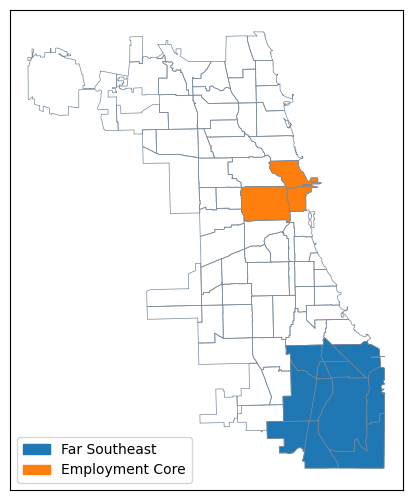

In [49]:
fig, ax = plt.subplots()

neighborhoods_shp.plot(
    facecolor="none", edgecolor="lightslategray", linewidth=0.5, ax=ax
)

neighborhoods_shp[neighborhoods_shp["far_southeast"] == 1].plot(
    label="Far Southeast",
    legend=True,
    facecolor="tab:blue",
    edgecolor="lightslategray",
    linewidth=0.5,
    ax=ax,
)

neighborhoods_shp[neighborhoods_shp["employment_core"] == 1].plot(
    label="Employment Core",
    legend=True,
    facecolor="tab:orange",
    edgecolor="lightslategray",
    linewidth=0.5,
    ax=ax,
)

# Create legend patches
patch1 = mpatches.Patch(color="tab:blue", label="Far Southeast")
patch2 = mpatches.Patch(color="tab:orange", label="Employment Core")

# Add legend to the plot
plt.legend(handles=[patch1, patch2], loc="lower left")

# Finaly styling
plt.xticks([])
plt.yticks([])
plt.tight_layout(pad=0)
plt.savefig("../out/shock_map.png", bbox_inches="tight")
plt.show()

In [50]:
# Plot the shock (A_hat)
# productivity_shock_shp.plot(
#     column="A_hat",
#     legend=True,
#     edgecolor="lightslategray",
#     linewidth=0.5,
#     cmap="inferno",
# )
# plt.xticks([])
# plt.yticks([])
# plt.tight_layout(pad=0)
# plt.savefig("../out/prod.png", bbox_inches="tight")
# plt.show()

In [51]:
# # Onto the endogenous variables
# # w_hat (all neighborhoods)
# productivity_shock_shp.plot(
#     column="w_hat",
#     legend=True,
#     edgecolor="lightslategray",
#     linewidth=0.5,
#     vmin=1.000,
#     vmax=1.025,
#     cmap="inferno",
# )
# plt.xticks([])
# plt.yticks([])
# plt.title("Model A")
# plt.tight_layout(pad=0)
# plt.savefig("../out/prod_mA_w_hat_all.png", bbox_inches="tight")
# plt.show()

# # w_hat (exclude far southeast)
# fig, ax = plt.subplots()

# # Full boundaries
# productivity_shock_shp.plot(
#     facecolor="none", edgecolor="lightslategray", linewidth=0.5, ax=ax
# )
# productivity_shock_shp[productivity_shock_shp["far_southeast"] == 0].plot(
#     column="w_hat",
#     legend=True,
#     edgecolor="lightslategray",
#     linewidth=0.5,
#     ax=ax,
#     vmin=1.0003,
#     vmax=1.0011,
#     cmap="inferno",
# )
# plt.xticks([])
# plt.yticks([])
# plt.title("Model A")
# plt.tight_layout(pad=0)
# plt.savefig("../out/prod_mA_w_hat_excl.png", bbox_inches="tight")
# plt.show()

# # w_hat (only far southeast)
# productivity_shock_shp[productivity_shock_shp['far_southeast'] == 1].plot(
#     column="w_hat",
#     legend=True,
#     edgecolor="lightslategray",
#     linewidth=0.5,
#     vmin=1.023,
#     vmax=1.025,
#     cmap="inferno",
# )
# plt.xticks([])
# plt.yticks([])
# plt.title("Model A")
# plt.tight_layout(pad=0)
# plt.savefig("../out/prod_mA_w_hat_fse.png", bbox_inches="tight")
# plt.show()

In [52]:
# # Plot the shock (kappa_hat)
# fig, ax = plt.subplots()

# transport_shock_shp.plot(
#     column="kappa_hat",
#     legend=True,
#     edgecolor="lightslategray",
#     linewidth=0.5,
#     cmap="inferno",
#     ax=ax,
# )
# transport_shock_shp[transport_shock_shp["far_southeast"] == 1].plot(
#     facecolor="none", edgecolor="black", linewidth=0.5, ax=ax
# )

# plt.xticks([])
# plt.yticks([])
# plt.tight_layout(pad=0)
# plt.savefig("../out/trans.png", bbox_inches="tight")
# plt.show()

In [53]:
# # Onto the endogenous variables
# # w_hat (all neighborhoods)
# transport_shock_shp.plot(
#     column="w_hat",
#     legend=True,
#     edgecolor="lightslategray",
#     linewidth=0.5,
#     vmin=0.999,
#     vmax=1.010,
#     cmap="inferno",
# )
# plt.xticks([])
# plt.yticks([])
# plt.title("Model A")
# plt.tight_layout(pad=0)
# plt.savefig("../out/trans_mA_w_hat_all.png", bbox_inches="tight")
# plt.show()

# # w_hat (exclude far southeast)
# fig, ax = plt.subplots()

# # Full boundaries
# transport_shock_shp.plot(
#     facecolor="none", edgecolor="lightslategray", linewidth=0.5, ax=ax
# )
# transport_shock_shp[transport_shock_shp["far_southeast"] == 0].plot(
#     column="w_hat",
#     legend=True,
#     edgecolor="lightslategray",
#     linewidth=0.5,
#     ax=ax,
#     vmin=0.999,
#     vmax=1.004,
#     cmap="inferno",
# )
# plt.xticks([])
# plt.yticks([])
# plt.title("Model A")
# plt.tight_layout(pad=0)
# plt.savefig("../out/trans_mA_w_hat_excl.png", bbox_inches="tight")
# plt.show()

# # w_hat (only far southeast)
# transport_shock_shp[transport_shock_shp['far_southeast'] == 1].plot(
#     column="w_hat",
#     legend=True,
#     edgecolor="lightslategray",
#     linewidth=0.5,
#     vmin=1.003,
#     vmax=1.010,
#     cmap="inferno",
# )
# plt.xticks([])
# plt.yticks([])
# plt.title("Model A")
# plt.tight_layout(pad=0)
# plt.savefig("../out/trans_mA_w_hat_fse.png", bbox_inches="tight")
# plt.show()

# # w_hat (only employment core)
# transport_shock_shp[transport_shock_shp['employment_core'] == 1].plot(
#     column="w_hat",
#     legend=True,
#     edgecolor="lightslategray",
#     linewidth=0.5,
#     vmin=0.9991,
#     vmax=0.9994,
#     cmap="inferno",
# )
# plt.xticks([])
# plt.yticks([])
# plt.title("Model A")
# plt.tight_layout(pad=0)
# plt.savefig("../out/trans_mA_w_hat_core.png", bbox_inches="tight")
# plt.show()